<a href="https://colab.research.google.com/github/lorenzrossi/MachineLearning/blob/master/Model_cnn_two_block.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from os import listdir
import pandas as pd
# Basic packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pickle

# Image preprocessing
import pathlib
import PIL
import PIL.Image
import cv2

# Neural Networks
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical, load_img, img_to_array
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers, callbacks, regularizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout, Activation
from keras.optimizers import Adam, SGD, RMSprop
from keras.losses import binary_crossentropy
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

# Cross Validation
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, zero_one_loss

tfk = tf.keras
tf.keras.backend.set_floatx("float64")
%load_ext tensorboard


from google.colab import drive
drive.mount('/content/drive')

dir = '/content/drive/MyDrive/CatsDogs'

Mounted at /content/drive


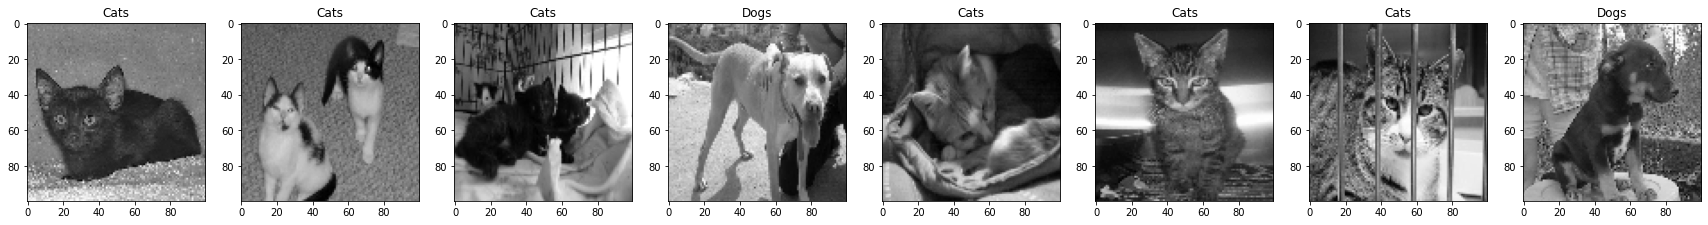

In [ ]:
X = pickle.load(open('/content/drive/MyDrive/CatsDogs/Pickles/X.pickle','rb'))
y = pickle.load(open('/content/drive/MyDrive/CatsDogs/Pickles/y.pickle','rb'))
#%%
pets_classes = ['Cats','Dogs']

images_to_plot = 8

gray_channel = 0

f, ax = plt.subplots(1, images_to_plot)
f.set_size_inches(30, 20)

for i in range(images_to_plot):
  gray_image = X[i][:, :, gray_channel]
  ax[i].imshow(gray_image, cmap = "gray")
  numeric_label = y[i]
  ax[i].set_title(pets_classes[numeric_label])

In [ ]:
number_of_classes = len(pets_classes)

In [ ]:
x_size, img_dim = X.shape[0], X.shape[1]

# rescale in [0,1]
X = tf.cast(X, tf.float32) / 255.0

# one hot encoding
depth = 1
y = tf.reshape(tf.one_hot(y, depth), shape = [x_size, depth])

In [ ]:
# Train test splitting
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

In [ ]:
# Hyperparameters
epoch = 50 # n of epochs
batch = 64 # batch size

# Defining the loss
loss = keras.losses.BinaryCrossentropy(from_logits = True)

# Defining the optimizer(s)
op_1 = Adam()
op_2 = SGD(learning_rate=0.01, momentum=0.9, decay=0.01/50)
op_3 = RMSprop(learning_rate=1e-4)

In [ ]:
# Defining plots
legend_size = 14

def performance_plot(history):
    plt.figure(figsize=(20,8))

    # Loss plots
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss', size = 12)
    plt.xlabel('epoch', size = 12)
    plt.legend(['train','val'], fontsize = legend_size)

    # Accuracy plots
    plt.subplot(1,2,2)
    plt.plot(history.history['binary_accuracy'])
    plt.plot(history.history['val_binary_accuracy'])
    plt.ylabel('accuracy', size = 12)
    plt.xlabel('epoch', size = 12)
    plt.legend(['train','val'], fontsize = legend_size)

    plt.show()

# Models
Model 1 is the base architecture

Model 2 adds dropout layers

Model 3 adds batch normalization layers 

In [ ]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, use_bias=False, activation='relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      288       
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      9216      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 64)        18432     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 64)        36864     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                    

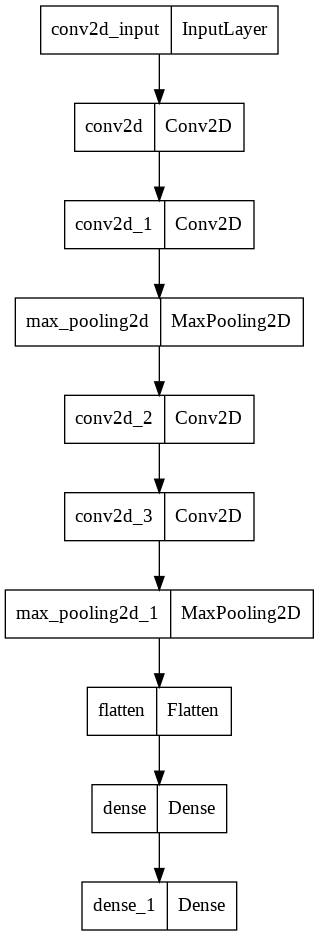

In [ ]:
keras.utils.plot_model(model1, 'model1.png')

In [ ]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, use_bias=False, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 100, 100, 32)      288       
                                                                 
 conv2d_5 (Conv2D)           (None, 100, 100, 32)      9216      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 50, 50, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 50, 50, 64)        18432     
                                                                 
 conv2d_7 (Conv2D)           (None, 50, 50, 64)        36864     
                                                      

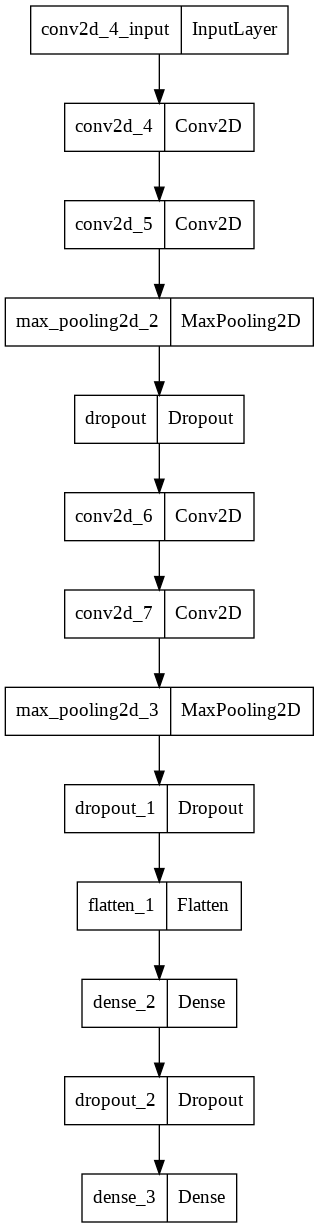

In [ ]:
keras.utils.plot_model(model2, 'model2.png')

In [ ]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 100, 100, 32)      288       
                                                                 
 batch_normalization (BatchN  (None, 100, 100, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_9 (Conv2D)           (None, 100, 100, 32)      9216      
                                                                 
 batch_normalization_1 (Batc  (None, 100, 100, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                      

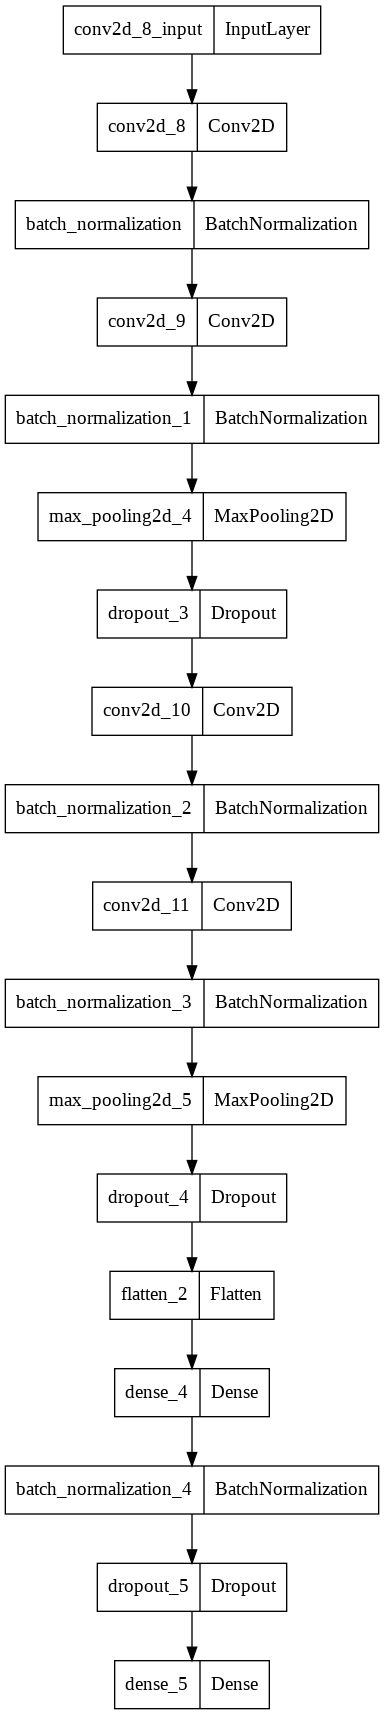

In [ ]:
keras.utils.plot_model(model3, 'model3.png')

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


313/313 [==============================] - 22s 35ms/step - loss: 0.6596 - binary_accuracy: 0.5996 - val_loss: 0.6815 - val_binary_accuracy: 0.6335
Epoch 2/50
313/313 [==============================] - 11s 34ms/step - loss: 0.5286 - binary_accuracy: 0.7365 - val_loss: 0.5001 - val_binary_accuracy: 0.7592
Epoch 3/50
313/313 [==============================] - 11s 34ms/step - loss: 0.4215 - binary_accuracy: 0.8056 - val_loss: 0.4277 - val_binary_accuracy: 0.8026
Epoch 4/50
313/313 [==============================] - 11s 34ms/step - loss: 0.3326 - binary_accuracy: 0.8559 - val_loss: 0.4163 - val_binary_accuracy: 0.8124
Epoch 5/50
313/313 [==============================] - 11s 34ms/step - loss: 0.2280 - binary_accuracy: 0.9048 - val_loss: 0.4621 - val_binary_accuracy: 0.8104
Epoch 6/50
313/313 [==============================] - 11s 34ms/step - loss: 0.1244 - binary_accuracy: 0.9527 - val_loss: 0.5767 - val_binary_accuracy: 0.8114
Epoch 7/50
313/313 [==============================] - 11s 34ms/

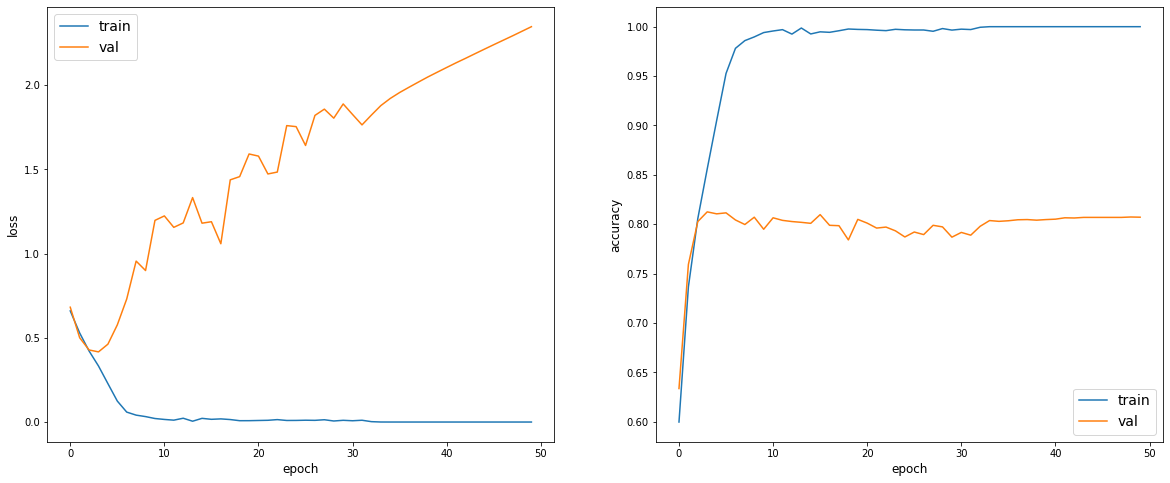

157/157 [==============================] - 1s 9ms/step - loss: 2.3464 - binary_accuracy: 0.8070
test loss, test acc: [2.3463887979239355, 0.8070456365092074]


In [ ]:
# TRAINING MODEL 1

# compiling the model
model1.compile(optimizer = op_1, loss=loss, metrics=['binary_accuracy'])

history = model1.fit(X_train, y_train, epochs = epoch, batch_size = batch, verbose = 1, validation_data = (X_test, y_test))

performance_plot(history)

result_1 = model1.evaluate(X_test, y_test)
print("test loss, test acc:", result_1)

Epoch 1/50
313/313 [==============================] - 12s 35ms/step - loss: 0.6948 - binary_accuracy: 0.4998 - val_loss: 0.6932 - val_binary_accuracy: 0.4900
Epoch 2/50
313/313 [==============================] - 11s 34ms/step - loss: 0.6905 - binary_accuracy: 0.5229 - val_loss: 0.6985 - val_binary_accuracy: 0.5256
Epoch 3/50
313/313 [==============================] - 11s 35ms/step - loss: 0.6789 - binary_accuracy: 0.5664 - val_loss: 0.6778 - val_binary_accuracy: 0.6029
Epoch 4/50
313/313 [==============================] - 11s 35ms/step - loss: 0.6132 - binary_accuracy: 0.6659 - val_loss: 0.5944 - val_binary_accuracy: 0.7072
Epoch 5/50
313/313 [==============================] - 11s 35ms/step - loss: 0.5430 - binary_accuracy: 0.7270 - val_loss: 0.6019 - val_binary_accuracy: 0.6920
Epoch 6/50
313/313 [==============================] - 11s 35ms/step - loss: 0.4908 - binary_accuracy: 0.7663 - val_loss: 0.5465 - val_binary_accuracy: 0.7176
Epoch 7/50
313/313 [==============================] 

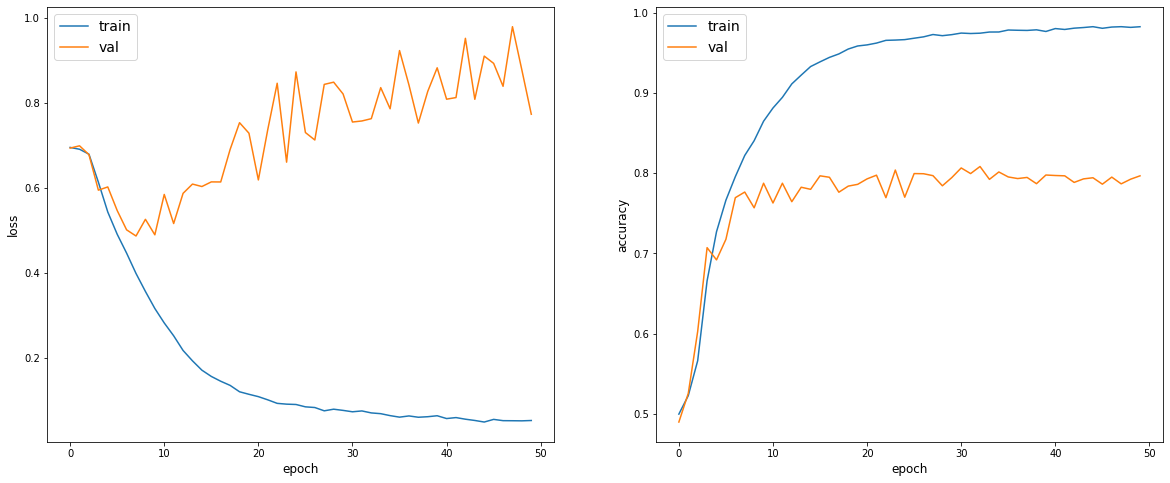

157/157 [==============================] - 1s 9ms/step - loss: 0.7727 - binary_accuracy: 0.7966
test loss, test acc: [0.7727101259866835, 0.7966373098478783]


In [ ]:
# TRAINING MODEL 2

# compiling the model
model2.compile(optimizer = op_1, loss=loss, metrics=['binary_accuracy'])

history = model2.fit(X_train, y_train, epochs = epoch, batch_size = batch, verbose = 1, validation_data = (X_test, y_test))

performance_plot(history)

result_2 = model2.evaluate(X_test, y_test)
print("test loss, test acc:", result_2)

Epoch 1/50
313/313 [==============================] - 21s 59ms/step - loss: 0.6544 - binary_accuracy: 0.6528 - val_loss: 0.7344 - val_binary_accuracy: 0.5280
Epoch 2/50
313/313 [==============================] - 18s 58ms/step - loss: 0.5185 - binary_accuracy: 0.7432 - val_loss: 0.5335 - val_binary_accuracy: 0.7248
Epoch 3/50
313/313 [==============================] - 18s 58ms/step - loss: 0.4519 - binary_accuracy: 0.7903 - val_loss: 0.5328 - val_binary_accuracy: 0.7368
Epoch 4/50
313/313 [==============================] - 18s 58ms/step - loss: 0.3918 - binary_accuracy: 0.8241 - val_loss: 0.4189 - val_binary_accuracy: 0.8040
Epoch 5/50
313/313 [==============================] - 18s 58ms/step - loss: 0.3342 - binary_accuracy: 0.8535 - val_loss: 0.5056 - val_binary_accuracy: 0.7726
Epoch 6/50
313/313 [==============================] - 18s 58ms/step - loss: 0.2816 - binary_accuracy: 0.8837 - val_loss: 0.3972 - val_binary_accuracy: 0.8289
Epoch 7/50
313/313 [==============================] 

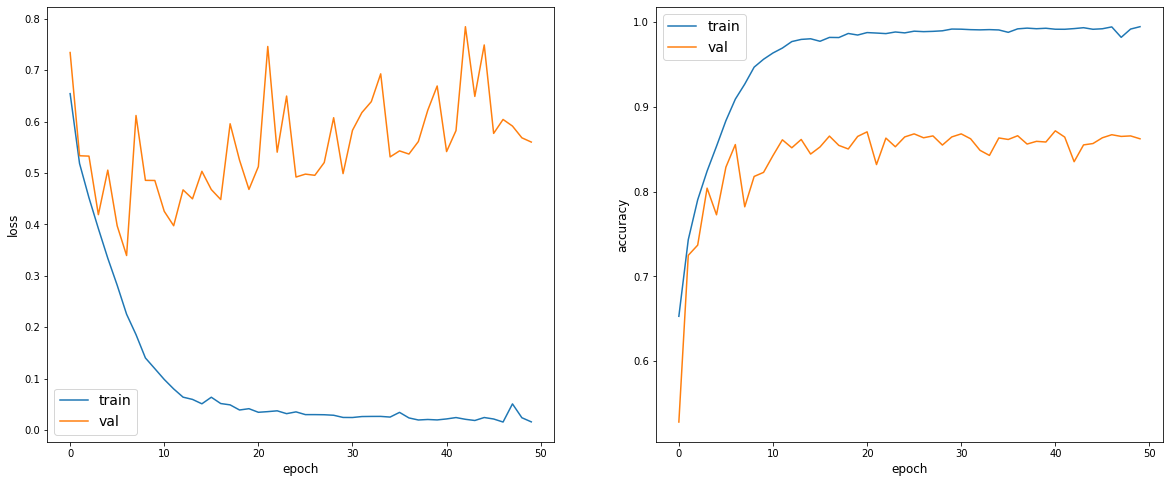

157/157 [==============================] - 2s 11ms/step - loss: 0.5602 - binary_accuracy: 0.8623
test loss, test acc: [0.560162061431943, 0.8622898318654924]


In [ ]:
# TRAINING MODEL 3 with Adam

# compiling the model
model3.compile(optimizer = op_1, loss=loss, metrics=['binary_accuracy'])

history = model3.fit(X_train, y_train, epochs = epoch, batch_size = batch, verbose = 1, validation_data = (X_test, y_test))

performance_plot(history)

result_op1 = model3.evaluate(X_test, y_test)
print("test loss, test acc:", result_op1)